In [187]:
!pip install word2number
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import string

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import plot_tree

import random
from word2number import w2n #using this to convert words to corresponding numbers.

In [188]:

# Getting an idea of how the data looks like

# Loading the dataset
df = pd.read_csv("bank_marketing_data.csv")

print("Glimpse of the data: \n", df.head())
print("Shape of the dataset: \n", df.shape)
print("Column types: \n", df.dtypes)

# Summarizing the categorical features
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
for c in cat_columns:
    print(f"Column {c} has the following values: ")
    print(df[c].value_counts().sort_index())

Glimpse of the data: 
    age           job   marital  education default  balance housing loan  \
0   58    management   married   tertiary      no     2143     yes   no   
1   44    technician    single  secondary      no       29     yes   no   
2   33  entrepreneur  married@  secondary      no        2     yes  yes   
3   47   blue-collar   married    unknown      no     1506     yes   no   
4   33       unknown    single    unknown      no        1      no   no   

   contact day month  duration  campaign  pdays  previous poutcome   y  \
0  unknown   5   may       261         1     -1         0  unknown  no   
1  unknown   5   may       151         1     -1         0  unknown  no   
2  unknown   5   may        76         1     -1         0  unknown  no   
3  unknown   5   may        92         1     -1         0  unknown  no   
4  unknown   5   may       198         1     -1         0  unknown  no   

  y_duplicate job_duplicate  
0          no    management  
1          no    tech

In [189]:
# --------- DATA CLEANING ---------

# Step 1: Drop NaN values
nanColumns = df.columns[df.isna().any()].tolist()
print("We will drop nan values in these columns: ", nanColumns)
df.dropna(inplace=True)

# Step 2: Drop duplicate rows
df.drop_duplicates(inplace=True)


# Step 3: Drop duplicate columns if any (we see that the last two columns are duplicate)
df = df.drop(columns=['y_duplicate', 'job_duplicate'])


# Step 4: Normalize cases (converting all strings to lowercase)
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
print(cat_columns)
for c in cat_columns:
    df[c] = df[c].str.lower()

print(df['marital'].unique())
# Step 5: Removing special chsracters
for c in cat_columns:
    df[c] = df[c].str.replace('[{}]'.format(string.punctuation), '')


# Step 6: Remove any unnecessary spaces
for c in cat_columns:
    df[c] = df[c].str.replace(' ', '')

# Step 7: Fixing spelling mistakes observed in the data
df['job'] = df['job'].replace({'technicin': 'technician'})


# Step 8: Removing rows with job as Unknown values
df = df[df['job'] != 'unknown']
df = df[df['education'] != 'unknown']

#Step 9: Removing non-sensical values
df = df[df['age'] != '-1']

# To drop rows with NaN values in a specific column
df.dropna(subset=['marital'], inplace=True)

print(df['marital'].unique())

#step10 : convert words to corresponding integer
#we found that there are some words like five,eight in day column which is a integer column. Converting  these words to corresponding integers()five to 5,eight to 8)
def convert_words_to_numbers(word):
    try:
        return w2n.word_to_num(word)
    except ValueError:
        return word  # If the word is not a valid number, keep it as is

# Apply the custom function to the column 'day'
df['day'] = df['day'].apply(convert_words_to_numbers)

# Step 11: Convert categorical columns to code values (int)
#for c in cat_columns:
#    df[c]=pd.factorize(df[c])[0]

marital_labels = {'married' : 0, 'single' : 1, 'divorced' : 2}
df['marital'] = df['marital'].map(marital_labels)

education_labels = {'primary' : 0, 'secondary' : 1, 'tertiary' : 2}
df['education'] = df['education'].map(education_labels)

yn = {'no' : 0, 'yes' : 1}
df['default'] = df['default'].map(yn)
df['housing'] = df['housing'].map(yn)
df['loan'] = df['loan'].map(yn)
df['y'] = df['y'].map(yn)

contact_labels = {'cellular' : 0, 'telephone' : 1, 'unknown' : 2}
df['contact'] = df['contact'].map(contact_labels)

month_labels = {'jan' : 1, 'feb' : 2, 'mar' : 3, 'apr' : 4, 'may' : 5, 'jun' : 6, 'jul' : 7, 'aug' : 8, 'sep' : 9, 'oct' : 10,'nov' : 11, 'dec' : 12}
df['month'] = df['month'].map(month_labels)

poutcome_labels = {'failure' : 0, 'success' : 1, 'unknown' : 2 ,'other' : 3}
df['poutcome'] = df['poutcome'].map(poutcome_labels)

job_labels = {'admin' : 0, 'bluecollar' : 1, 'entrepreneur' : 2, 'housemaid' : 3, 'management' : 4, 'retired' : 5, 'selfemployed' : 6, 'services' : 7, 'student' : 8, 'technician' : 9, 'unemployed' : 10}
df['job'] = df['job'].map(job_labels)



We will drop nan values in these columns:  ['y_duplicate', 'job_duplicate']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome', 'y']
['married' 'single' 'married@' 'divorced' 'single@' 'divorced@']


<ipython-input-189-606c150fd383>:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df[c] = df[c].str.replace('[{}]'.format(string.punctuation), '')


['married' 'single' 'divorced']


In [190]:
# -------- EXPLORATORY DATA ANALYSIS --------

print("Statistical summary of data: \n",df.describe())
print("Column types: \n", df.dtypes)

Statistical summary of data: 
                 age           job       marital     education       default  \
count  43193.000000  43193.000000  43193.000000  43193.000000  43193.000000   
mean      40.764082      4.298775      0.515709      1.149608      0.018105   
std       10.512640      3.238402      0.694680      0.664907      0.133332   
min       18.000000      0.000000      0.000000      0.000000      0.000000   
25%       33.000000      1.000000      0.000000      1.000000      0.000000   
50%       39.000000      4.000000      0.000000      1.000000      0.000000   
75%       48.000000      7.000000      1.000000      2.000000      0.000000   
max       95.000000     10.000000      2.000000      2.000000      1.000000   

             balance       housing          loan       contact           day  \
count   43193.000000  43193.000000  43193.000000  43193.000000  43193.000000   
mean     1354.027342      0.562406      0.164541      0.631260     15.809414   
std      3042.103

In [191]:
# Step 1: John Tukey - 1.3.5.1 Measures of Location

quant_columns = ['age', 'balance', 'duration']

# Calculating the mean, median and mode for the above columns
for c in quant_columns:
  mean = df[c].mean()
  median = df[c].median()
  mode = df[c].mode().values[0]
  num_modes = len(df[c].mode())
  print(f"Mean of column '{c}': {mean}")
  print(f"Median of column '{c}': {median}")
  print(f"Mode of column '{c}': {mode}")
  print(f"Number of Modes for column {c}: {num_modes}")


Mean of column 'age': 40.76408214293983
Median of column 'age': 39.0
Mode of column 'age': 32
Number of Modes for column age: 1
Mean of column 'balance': 1354.0273423934434
Median of column 'balance': 442.0
Mode of column 'balance': 0
Number of Modes for column balance: 1
Mean of column 'duration': 258.32340888569905
Median of column 'duration': 180.0
Mode of column 'duration': 124
Number of Modes for column duration: 1


In [192]:
# Step 2: John Tukey - 1.3.5.2 Confidence Limits for the Mean

# Calculating the mean and 95% confidence interval for the columns
for c in quant_columns:
  confidence_interval = stats.t.interval(0.95, df = (len(c) - 1), loc = df[c].mean(), scale = df[c].std())
  print(f"For column '{c}' Mean: {df[c].mean()}")
  print(f"For column '{c}' Confidence Interval (95%): {confidence_interval}")


For column 'age' Mean: 40.76408214293983
For column 'age' Confidence Interval (95%): (-4.468158055077211, 85.99632234095687)
For column 'balance' Mean: 1354.0273423934434
For column 'balance' Confidence Interval (95%): (-6089.732063338076, 8797.786748124963)
For column 'duration' Mean: 258.32340888569905
For column 'duration' Confidence Interval (95%): (-352.13273122318, 868.7795489945781)


In [193]:
# Step 3: John Tukey - 1.3.5.6 Measures of Scale

# Calculating the variance, standard deviation, range and interquartile range
for c in quant_columns:
  variance = df[c].var()
  std_dev = df[c].std()
  iqr = df[c].quantile(0.75) - df[c].quantile(0.25)
  range = df[c].max() - df[c].min()
  print(f"Variance of column '{c}': {variance}")
  print(f"Standard Deviation of column '{c}': {std_dev}")
  print(f"IQR (Interquartile Range) of column '{c}': {iqr}")
  print(f"Range of column '{c}': {range}")

Variance of column 'age': 110.51560467300789
Standard Deviation of column 'age': 10.512640233214865
IQR (Interquartile Range) of column 'age': 15.0
Range of column 'age': 77
Variance of column 'balance': 9254394.46639907
Standard Deviation of column 'balance': 3042.1036251908104
IQR (Interquartile Range) of column 'balance': 1341.0
Range of column 'balance': 110146
Variance of column 'duration': 66647.62134889043
Standard Deviation of column 'duration': 258.16200601345355
IQR (Interquartile Range) of column 'duration': 215.0
Range of column 'duration': 4918


In [194]:
# Step 4: John Tukey -  1.3.5.11 Measures of Skewness and Kurtosis

# Measuring the skewness and kurtosis
for c in quant_columns:
  skewness = df[c].skew()
  kurtosis = df[c].kurt()
  print(f"Skewness for column {c}: {skewness}")
  print(f"Kurtosis for column {c}: {kurtosis}")

Skewness for column age: 0.6978356364509636
Kurtosis for column age: 0.31295414619805495
Skewness for column balance: 8.400120937754398
Kurtosis for column balance: 142.31740845151327
Skewness for column duration: 3.1701799697784785
Kurtosis for column duration: 18.46976460649803


In [195]:
# Step 5: John Tukey - 1.3.5.12 Autocorrelation

# Calculating the autocorrelation for every column
for c in quant_columns:
  autocorrelation = df[c].autocorr()
  print(f"Autocorrelation of column {c}: {autocorrelation}")

Autocorrelation of column age: 0.09718522915750336
Autocorrelation of column balance: 0.03850452379536643
Autocorrelation of column duration: 0.04510733583085448


In [196]:
# Step 6: John Tukey - 1.3.5.17. Detection of Outliers

print("Shape before removing outliers: ", df.shape)
threshold = 2
outlier_columns = ['balance', 'duration']

for c in outlier_columns:
    df = df.reset_index(drop=True)
    z_scores = np.abs(stats.zscore(df[c].values))
    outlier_indices = np.where(z_scores > threshold)[0]
    print(len(outlier_indices))
    # We noticed removing outliers reduced performance of our models so commented this
    # These outliers are probably not actually outliers in real world use case
    #df = df.drop(outlier_indices, axis = 0)


Shape before removing outliers:  (43193, 17)
1399
2006


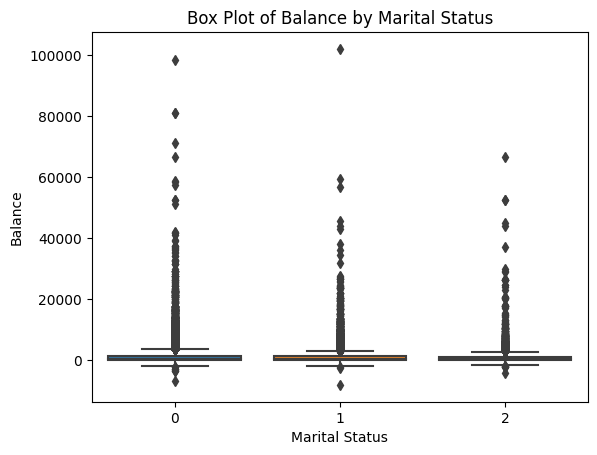

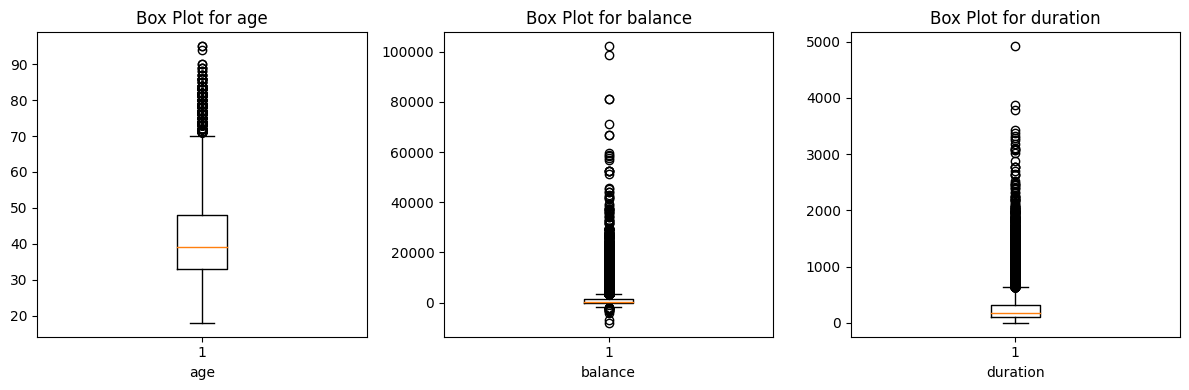

In [197]:
# Step 7: John Tukey - 1.3.3.7 Box Plot

# Trying to analyse any relationship of marital status with balance using box plot
sns.boxplot(x = 'marital', y = 'balance', data = df)
plt.xlabel('Marital Status')
plt.ylabel('Balance')
plt.title('Box Plot of Balance by Marital Status')
plt.show()

# Trying to understand variation in values of the columns using box plot
fig, axes = plt.subplots(1, len(quant_columns), figsize=(12, 4))
for i, c in enumerate(quant_columns):
    axes[i].boxplot(df[c])
    axes[i].set_title('Box Plot for ' + c)
    axes[i].set_xlabel(c)
plt.tight_layout()
plt.show()


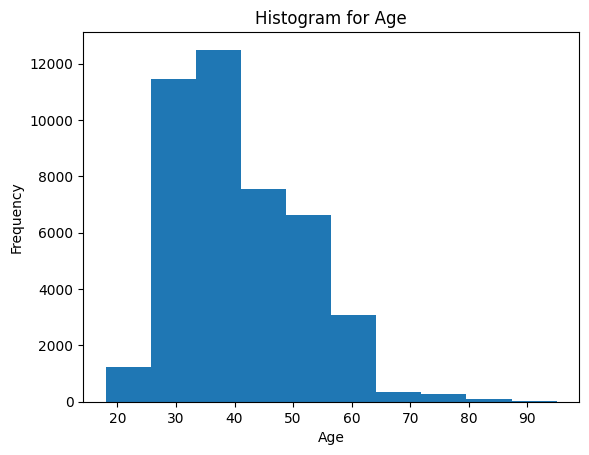

In [198]:
# Step 8: John Tukey - 1.3.3.14 Histogram

# Understanding distribution of age using histogram
plt.hist(df['age'], bins = 10)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram for Age')
plt.show()

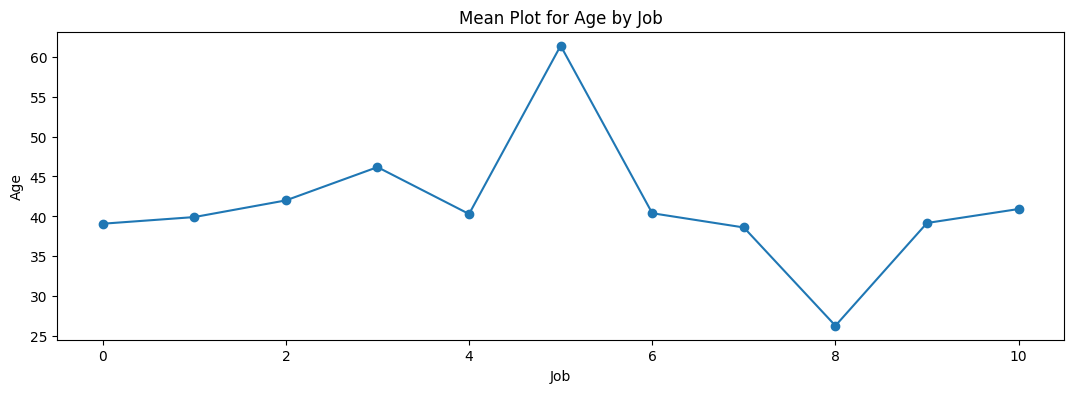

In [199]:
# Step 9: John Tukey - 1.3.3.20 Mean Plot

# Plotting a mean plot to understand position of age values by job
mean_values = df.groupby('job')['age'].mean().reset_index()
plt.figure(figsize=(13,4))
plt.plot(mean_values['job'], mean_values['age'], marker='o')
plt.xlabel('Job')
plt.ylabel('Age')
plt.title('Mean Plot for Age by Job')
plt.show()


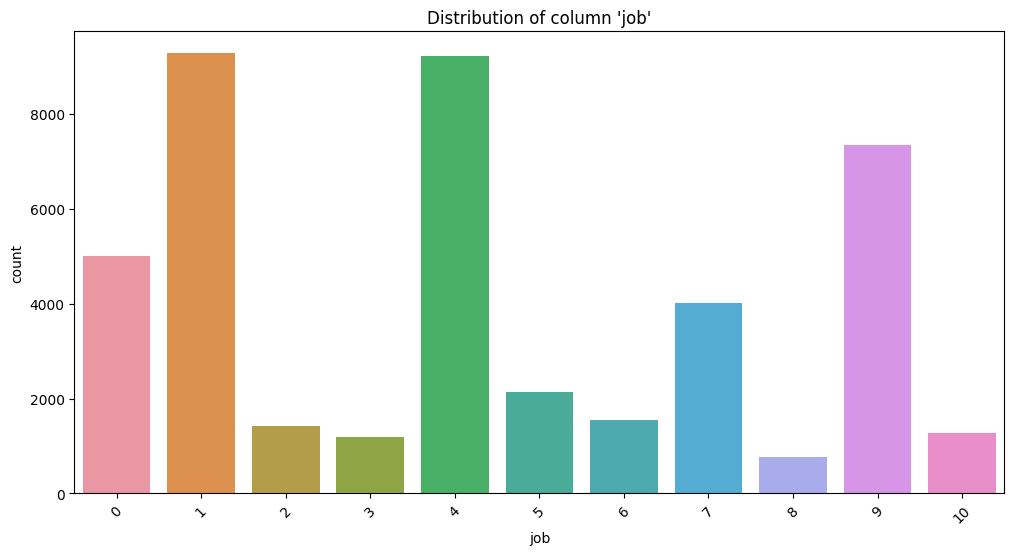

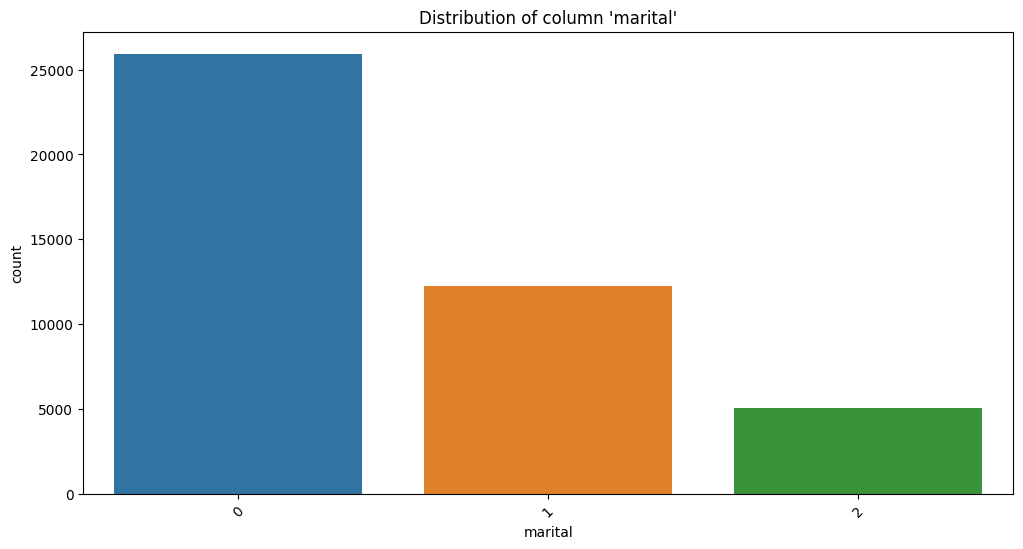

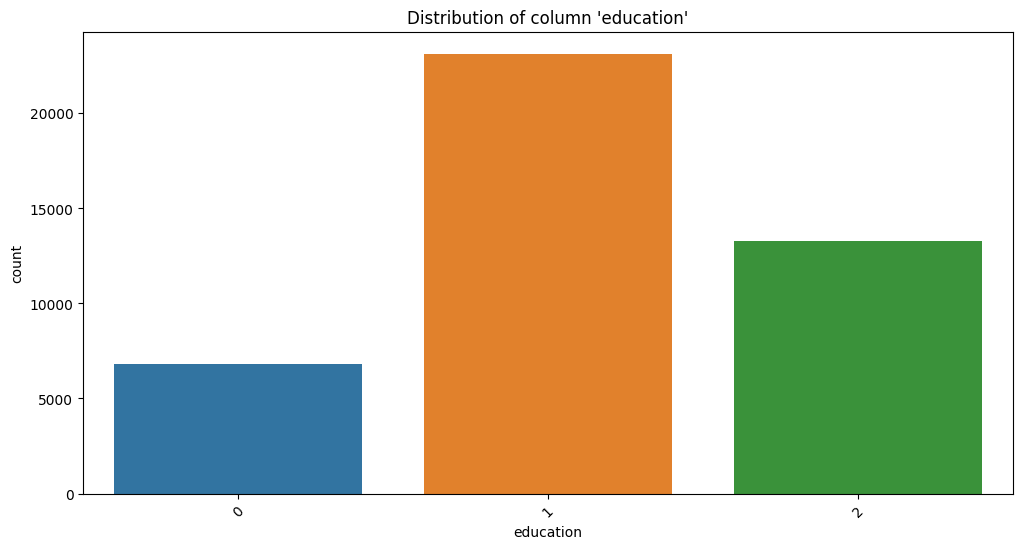

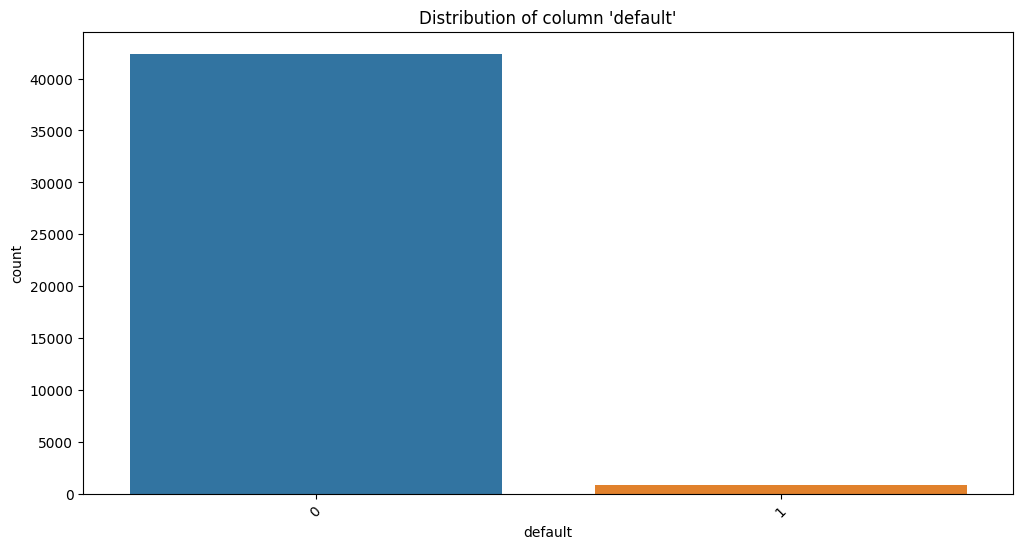

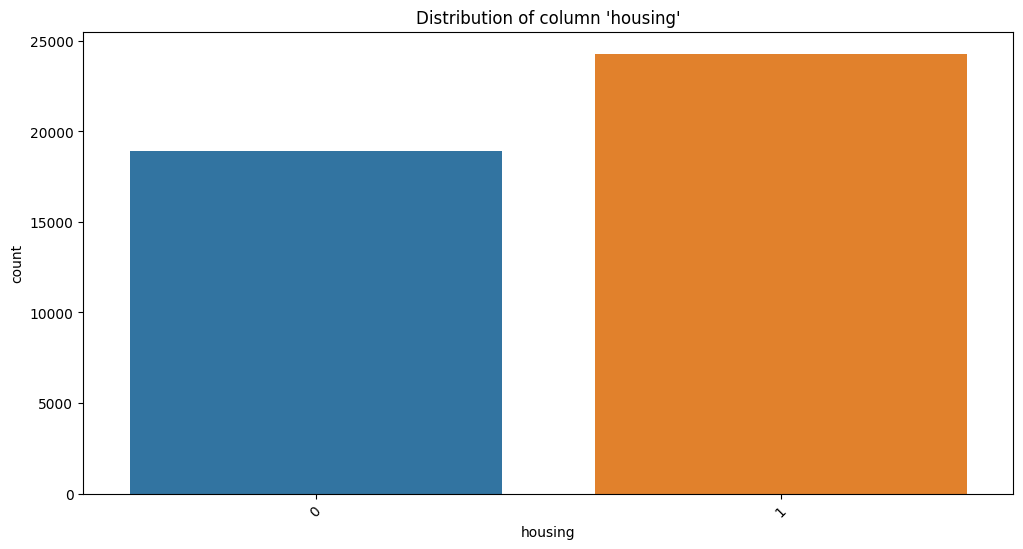

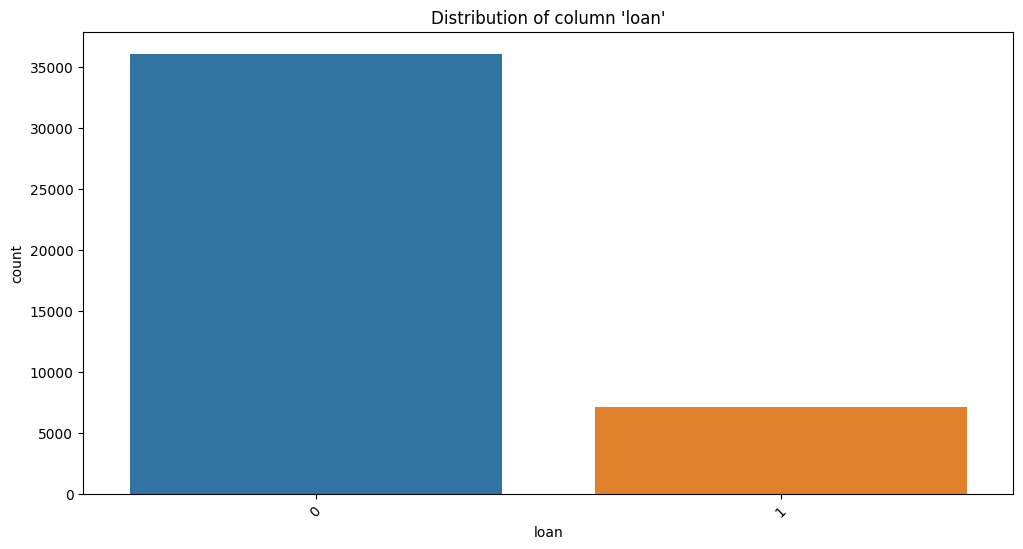

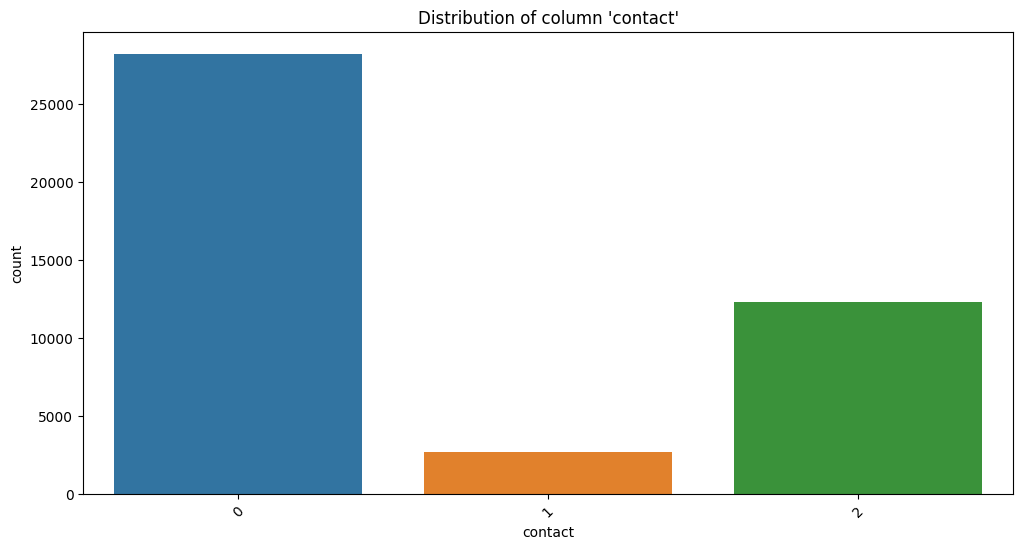

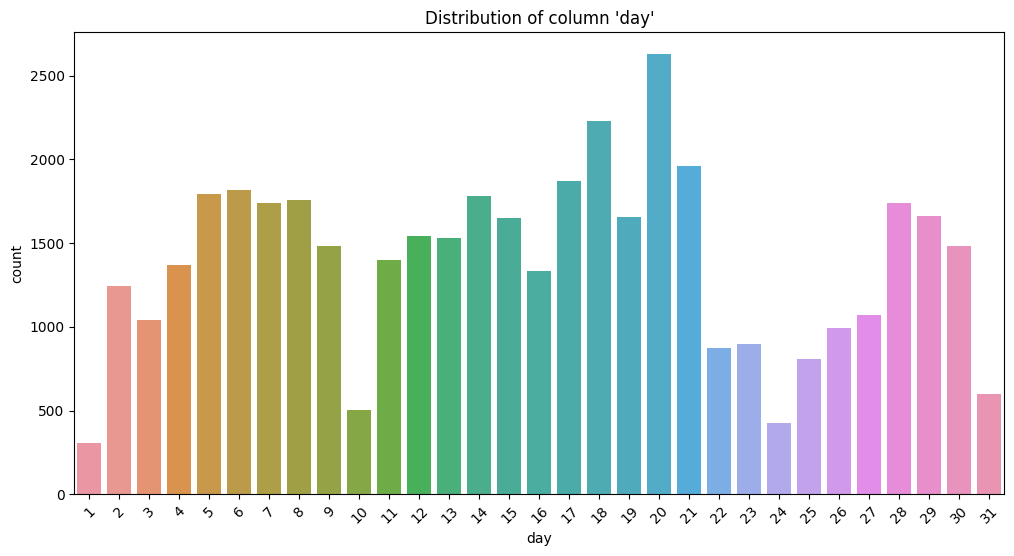

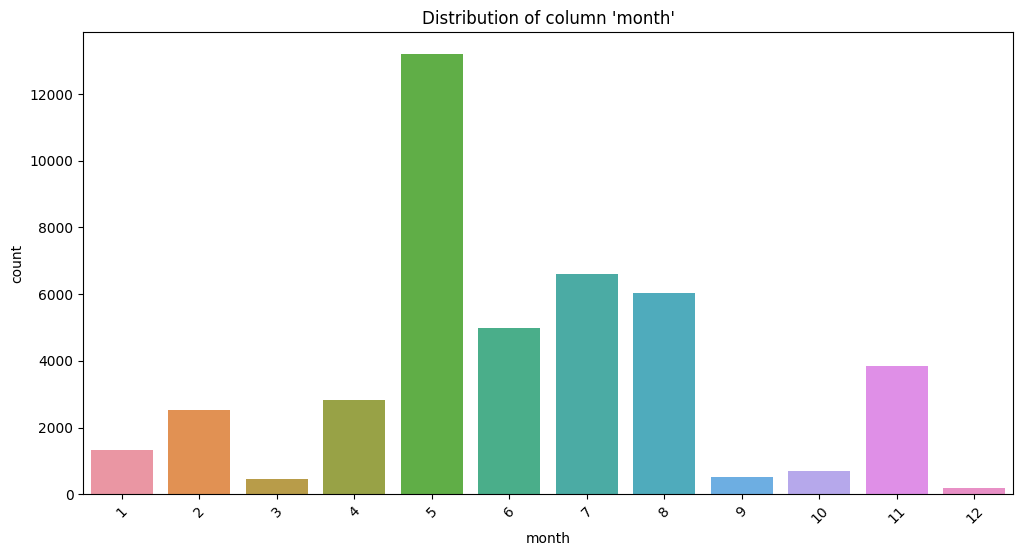

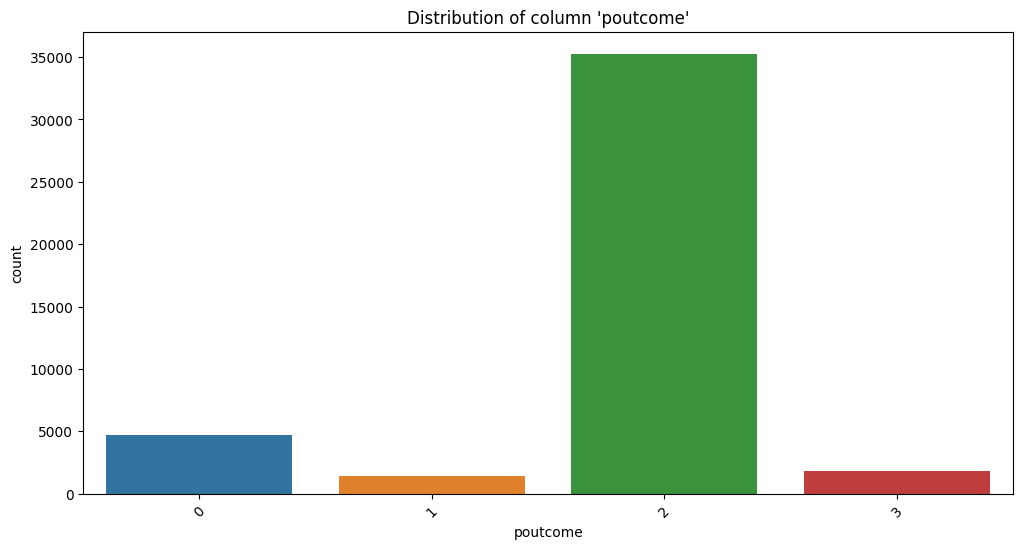

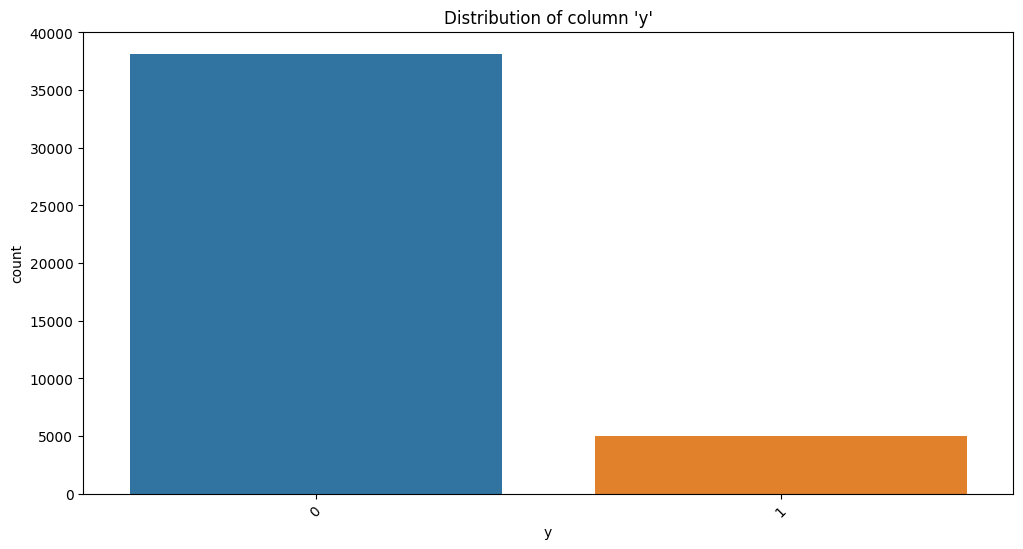

In [200]:
# Step 10: Count Plot to Visualize categorical features
for c in cat_columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(x = c, data = df)
    plt.title(f"Distribution of column '{c}'")
    plt.xticks(rotation=45)
    plt.show()

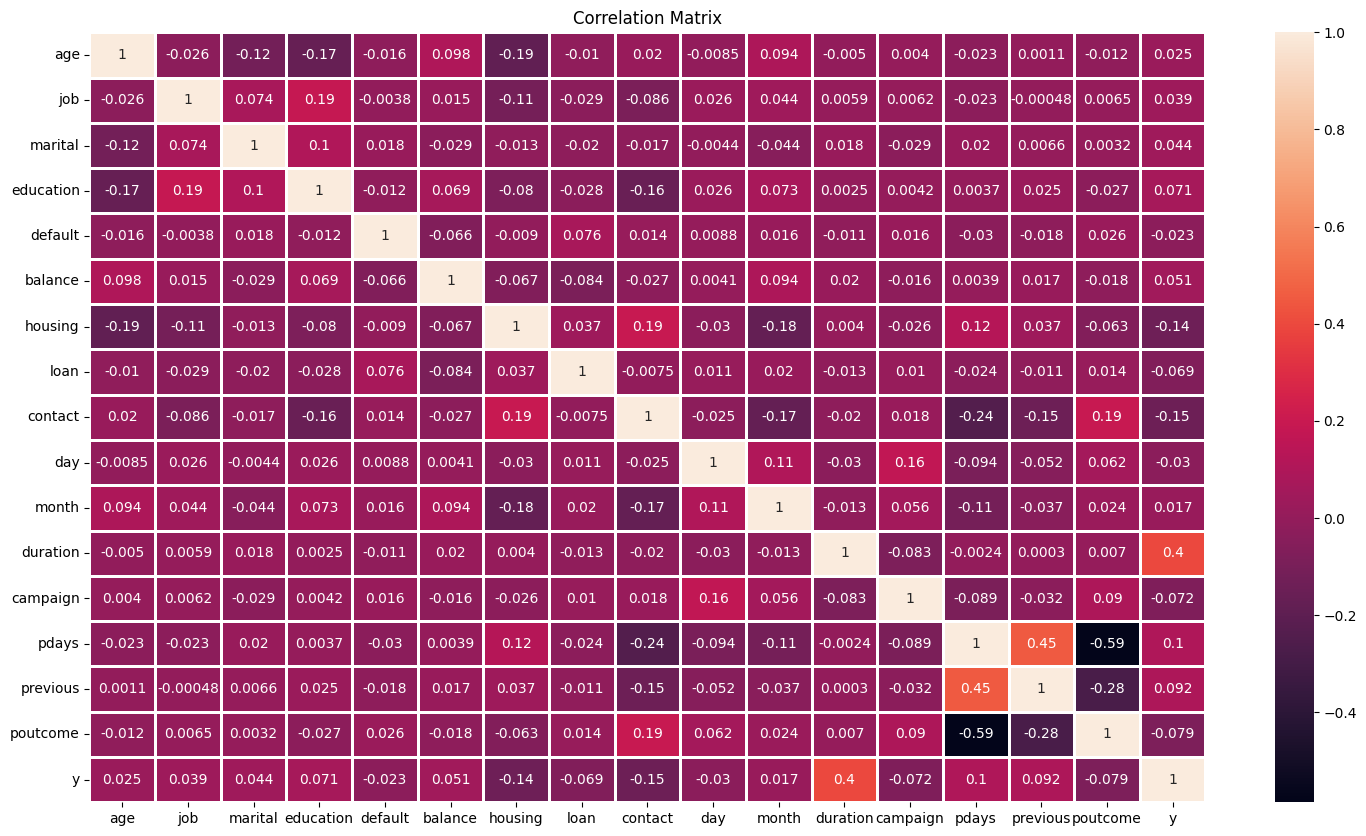

In [201]:
# Step 11: Correlation Matrix

# Creating a heatmap for correlation matrix to understand correlation between different columns
plt.figure(figsize=(18,10))
sns.heatmap(df.corr(), annot=True, linewidths = 1)
plt.title('Correlation Matrix')
plt.show()

In [202]:
# Step 12: Dropping columns

# Getting columns which have low correlation coeff values with column 'y'
corr_matrix = df.corr()
y_correlation = corr_matrix['y']
low_corr = y_correlation[(y_correlation < 0.07) & (y_correlation > -0.07)].index.tolist()
print("These columns have low correlations with column 'y': ", low_corr)

# Dropping the low correlation columns
df = df.drop(columns = low_corr)

These columns have low correlations with column 'y':  ['age', 'job', 'marital', 'default', 'balance', 'loan', 'day', 'month']


In [203]:
# Step 13: Normalization

# Normalizing below columns as they have a higher scale
columns=[ 'duration']
norm_columns=(df[columns] - df[columns].min())/(df[columns].max() - df[columns].min())
df[columns] = norm_columns

df.head(5)


,education,housing,contact,duration,campaign,pdays,previous,poutcome,y
0,2,1,2,0.053070,1,-1,0,2,0
1,1,1,2,0.030704,1,-1,0,2,0
2,1,1,2,0.015453,1,-1,0,2,0
3,2,1,2,0.028264,1,-1,0,2,0
4,2,1,2,0.044124,1,-1,0,2,0


In [204]:
# Randomly removing rows with zero to reduce skewedness
rows_with_zero_pred = df[df['y'] == 0].index
rows_to_remove = random.sample(rows_with_zero_pred.tolist(), int(len(rows_with_zero_pred) * 0.8))
df = df.drop(rows_to_remove)

In [ ]:
# ------------------------- Phase 2 -----------------------------

In [205]:
# Saving the Preproceesd CSV File
df.to_csv("preprocessed.csv", sep=',', index=False, encoding='utf-8')

In [206]:
# Create X and Y
X = df.drop(columns = ['y'])
Y = df['y']
print("Shape of X: ", X.shape)
print("Shape of Y: ", Y.shape)

# Splitting into training and testing set
X_train, X_test, y_train, y_test  = train_test_split(X, Y, test_size=0.2)

print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

# Array to hold accuracies of each model
accuracies = []

Shape of X:  (12656, 8)
Shape of Y:  (12656,)
Shape of X_train:  (10124, 8)
Shape of y_train:  (10124,)
Shape of X_test:  (2532, 8)
Shape of y_test:  (2532,)


Accuracy using SVM:  0.6544233807266983
Precision using SVM:  [0.65444288 0.65432099]
Recall using SVM:  [0.90861619 0.265     ]
F1 using SVM:  [0.76086362 0.3772242 ]


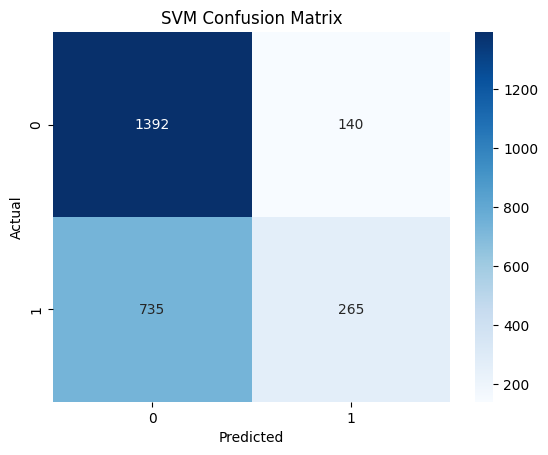

In [207]:
# Model 1 - SVM
svm_model = SVC(kernel = 'rbf')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("Accuracy using SVM: ", accuracy_score(y_test, y_pred_svm))
accuracies.append(accuracy_score(y_test, y_pred_svm))
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_svm)
print("Precision using SVM: ", precision)
print("Recall using SVM: ", recall)
print("F1 using SVM: ", f1)

# Displaying confusion matrix
svm_confusion_matrix = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(svm_confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()

# Getting ROC, AUC values
fpr_svm_model, tpr_svm_model, _ = roc_curve(y_test, y_pred_svm)
auc_svm_model = roc_auc_score(y_test, y_pred_svm)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy using Logistic Regression:  0.7788309636650869
Precision using Logistic Regression:  [0.7985258  0.74336283]
Recall using Logistic Regression:  [0.84856397 0.672     ]
F1 using Logistic Regression:  [0.82278481 0.70588235]


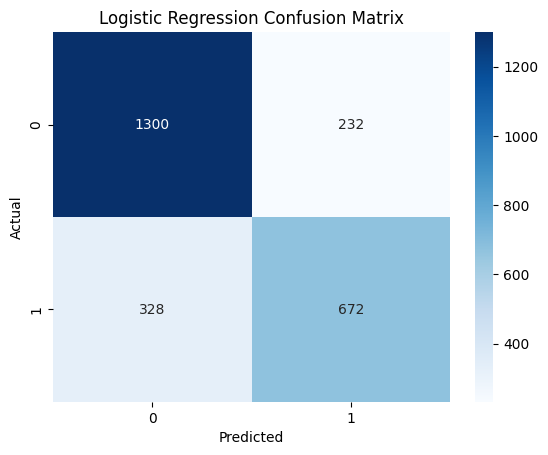

In [208]:
# Model 2 - Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
print("Accuracy using Logistic Regression: ", accuracy_score(y_test, y_pred_logistic))
accuracies.append(accuracy_score(y_test, y_pred_logistic))
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_logistic)
print("Precision using Logistic Regression: ", precision)
print("Recall using Logistic Regression: ", recall)
print("F1 using Logistic Regression: ", f1)

# Displaying confusion matrix
lr_confusion_matrix = confusion_matrix(y_test, y_pred_logistic)
sns.heatmap(lr_confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Getting ROC, AUC values
fpr_lr_model, tpr_lr_model, _ = roc_curve(y_test, y_pred_logistic)
auc_lr_model = roc_auc_score(y_test, y_pred_logistic)


Accuracy using KNN:  0.7606635071090048
Precision using KNN:  [0.8002594 0.6989899]
Recall using KNN:  [0.80548303 0.692     ]
F1 using KNN:  [0.80286272 0.69547739]


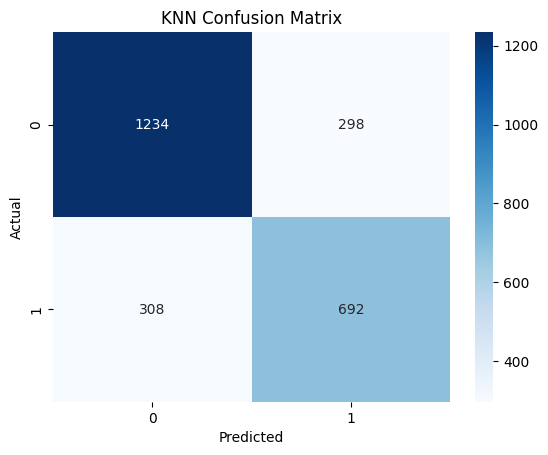

In [209]:
# Model 3 - KNN
knn_model = KNeighborsClassifier(n_neighbors = 5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print("Accuracy using KNN: ", accuracy_score(y_test, y_pred_knn))
accuracies.append(accuracy_score(y_test, y_pred_knn))
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_knn)
print("Precision using KNN: ", precision)
print("Recall using KNN: ", recall)
print("F1 using KNN: ", f1)

# Displaying confusion matrix
knn_confusion_matrix = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(knn_confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN Confusion Matrix")
plt.show()

# Getting ROC, AUC values
fpr_knn_model, tpr_knn_model, _ = roc_curve(y_test, y_pred_knn)
auc_knn_model = roc_auc_score(y_test, y_pred_knn)

Accuracy using Naive Bayes:  0.7318325434439179
Precision using Naive Bayes:  [0.76739812 0.67129136]
Recall using Naive Bayes:  [0.79895561 0.629     ]
F1 using Naive Bayes:  [0.78285897 0.64945792]


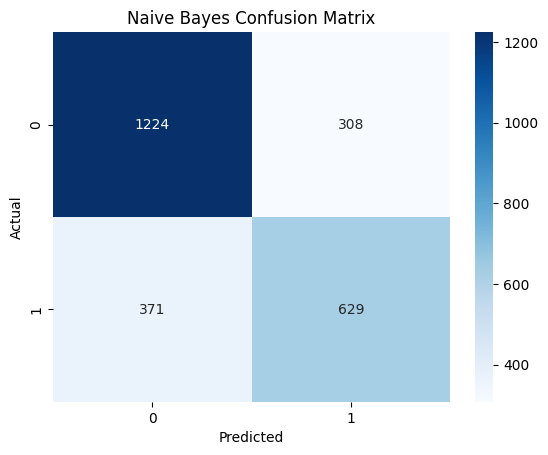

In [210]:
# Model 4 - Naive Bayes
naive_bayes_model = GaussianNB()
#naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)
y_pred_naive_bayes = naive_bayes_model.predict(X_test)
print("Accuracy using Naive Bayes: ", accuracy_score(y_test, y_pred_naive_bayes))
accuracies.append(accuracy_score(y_test, y_pred_naive_bayes))
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_naive_bayes)
print("Precision using Naive Bayes: ", precision)
print("Recall using Naive Bayes: ", recall)
print("F1 using Naive Bayes: ", f1)

# Displaying confusion matrix
nb_confusion_matrix = confusion_matrix(y_test, y_pred_naive_bayes)
sns.heatmap(nb_confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Naive Bayes Confusion Matrix")
plt.show()

# Getting ROC, AUC values
fpr_nb_model, tpr_nb_model, _ = roc_curve(y_test, y_pred_naive_bayes)
auc_nb_model = roc_auc_score(y_test, y_pred_naive_bayes)

Accuracy using Decision Tree:  0.7436808846761453
Precision using Decision Tree:  [0.78246961 0.68111455]
Recall using Decision Tree:  [0.79830287 0.66      ]
F1 using Decision Tree:  [0.79030695 0.67039106]


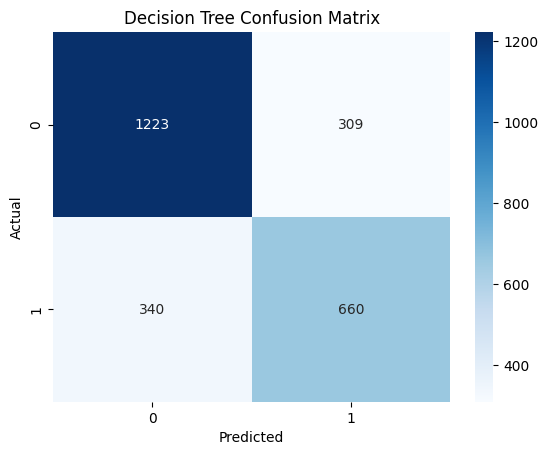

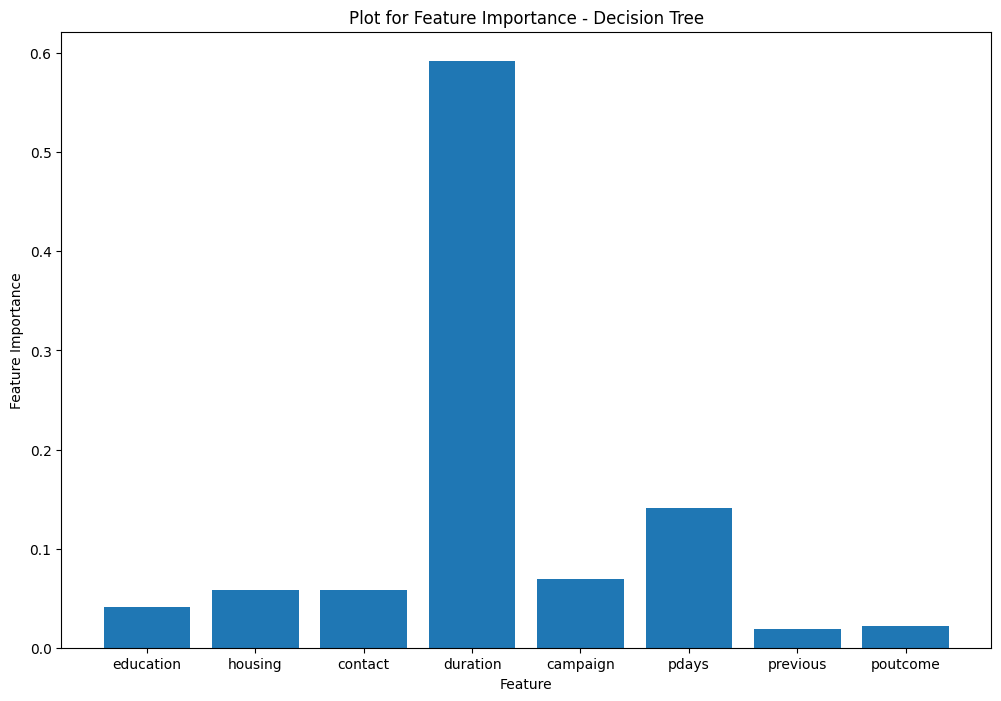

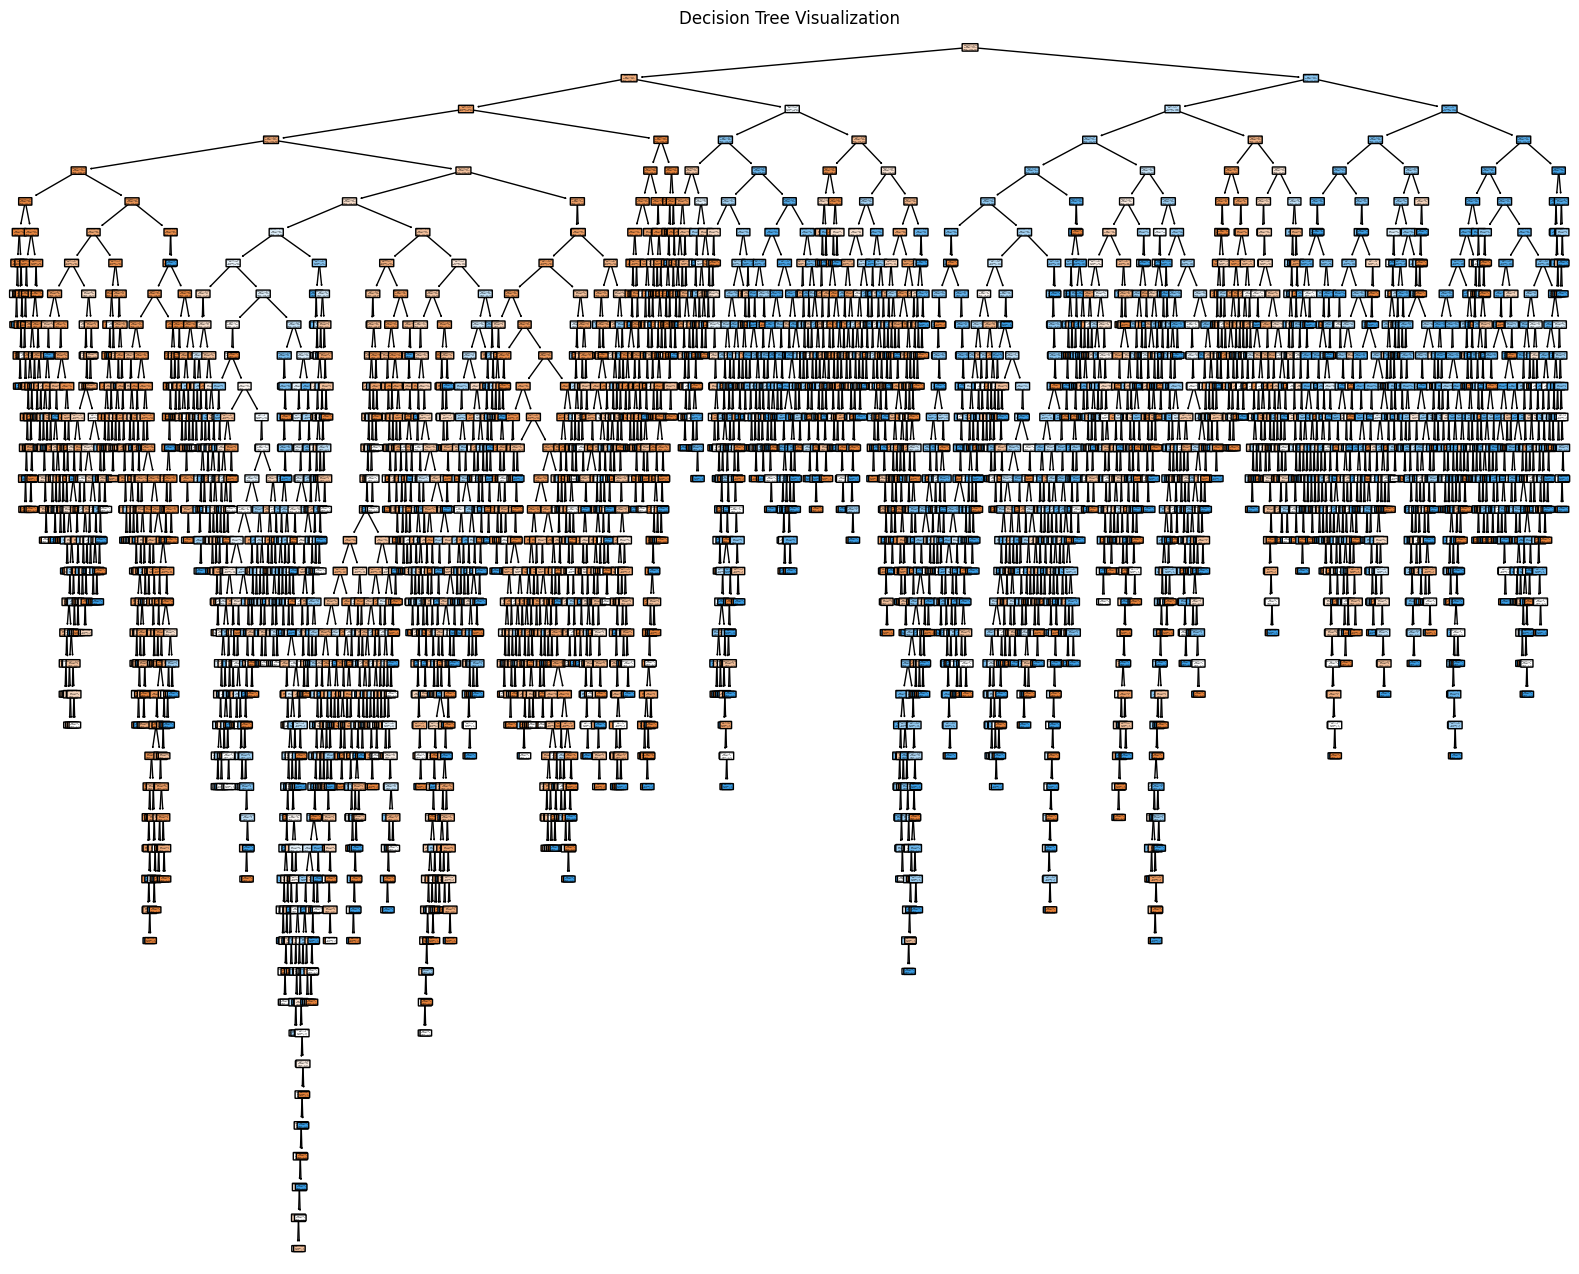

In [211]:
# Model 5 - Decision Tree
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)
y_pred_decision_tree = decision_tree_model.predict(X_test)
print("Accuracy using Decision Tree: ",  accuracy_score(y_test, y_pred_decision_tree))
accuracies.append(accuracy_score(y_test, y_pred_decision_tree))
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_decision_tree)
print("Precision using Decision Tree: ", precision)
print("Recall using Decision Tree: ", recall)
print("F1 using Decision Tree: ", f1)

# Displaying confusion matrix
dt_confusion_matrix = confusion_matrix(y_test, y_pred_decision_tree)
sns.heatmap(dt_confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree Confusion Matrix")
plt.show()

dt_feature_importance = decision_tree_model.feature_importances_
# Bar plot for plotting feature importance
plt.figure(figsize=(12, 8))
plt.bar([1,2,3,4,5,6,7,8], dt_feature_importance)
plt.xticks([1,2,3,4,5,6,7,8], X.columns)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Plot for Feature Importance - Decision Tree')
plt.show()

# Visual representation of decision tree
plt.figure(figsize=(20, 16))
plot_tree(decision_tree_model, feature_names=X.columns, class_names=["Label 0", "Label 1"], filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

# Getting ROC, AUC values
fpr_dt_model, tpr_dt_model, _ = roc_curve(y_test, y_pred_decision_tree)
auc_dt_model = roc_auc_score(y_test, y_pred_decision_tree)

Accuracy using Random Forest:  0.7784360189573459
Precision using Random Forest:  [0.82259136 0.71372931]
Recall using Random Forest:  [0.80809399 0.733     ]
F1 using Random Forest:  [0.81527824 0.72323631]


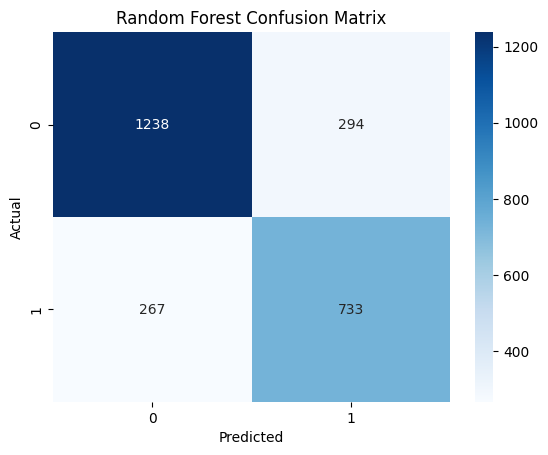

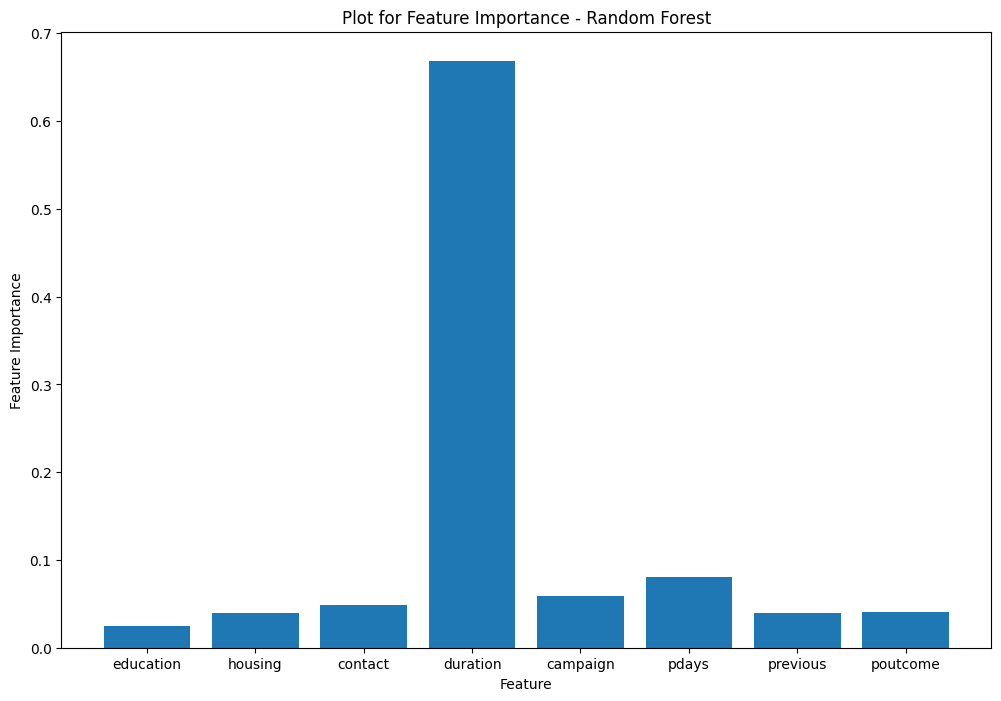

In [212]:
# Model 6 - Random forest
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)
y_pred_random_forest = random_forest_model.predict(X_test)
print("Accuracy using Random Forest: ",  accuracy_score(y_test, y_pred_random_forest))
accuracies.append(accuracy_score(y_test, y_pred_random_forest))
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_random_forest)
print("Precision using Random Forest: ", precision)
print("Recall using Random Forest: ", recall)
print("F1 using Random Forest: ", f1)

# Displaying confusion matrix
rf_confusion_matrix = confusion_matrix(y_test, y_pred_random_forest)
sns.heatmap(rf_confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

rf_feature_importance = random_forest_model.feature_importances_
# Bar plot for plotting feature importance
plt.figure(figsize=(12, 8))
plt.bar([1,2,3,4,5,6,7,8], rf_feature_importance)
plt.xticks([1,2,3,4,5,6,7,8], X.columns)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Plot for Feature Importance - Random Forest')
plt.show()

# Getting ROC, AUC values
fpr_rf_model, tpr_rf_model, _ = roc_curve(y_test, y_pred_random_forest)
auc_rf_model = roc_auc_score(y_test, y_pred_random_forest)

Accuracy using Voting classifier:  0.7733017377567141
Precision using Voting classifier:  [0.81596306 0.70964567]
Recall using Voting classifier:  [0.80744125 0.721     ]
F1 using Voting classifiert:  [0.81167979 0.71527778]


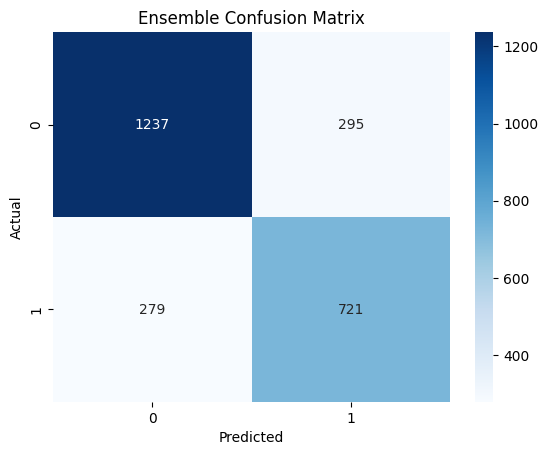

In [213]:
# Model 7 - Voting Classifier (Using logistic, KNN and Random Forest)

voting_model = VotingClassifier(estimators=[('logistic', decision_tree_model), ('knn', knn_model), ('random_forest', random_forest_model)])
voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)
print("Accuracy using Voting classifier: ",  accuracy_score(y_test, y_pred_voting))
accuracies.append(accuracy_score(y_test, y_pred_voting))
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_voting)
print("Precision using Voting classifier: ", precision)
print("Recall using Voting classifier: ", recall)
print("F1 using Voting classifiert: ", f1)

# Displaying confusion matrix
v_confusion_matrix = confusion_matrix(y_test, y_pred_voting)
sns.heatmap(v_confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Ensemble Confusion Matrix")
plt.show()

# Getting ROC, AUC values
fpr_v_model, tpr_v_model, _ = roc_curve(y_test, y_pred_voting)
auc_v_model = roc_auc_score(y_test, y_pred_voting)

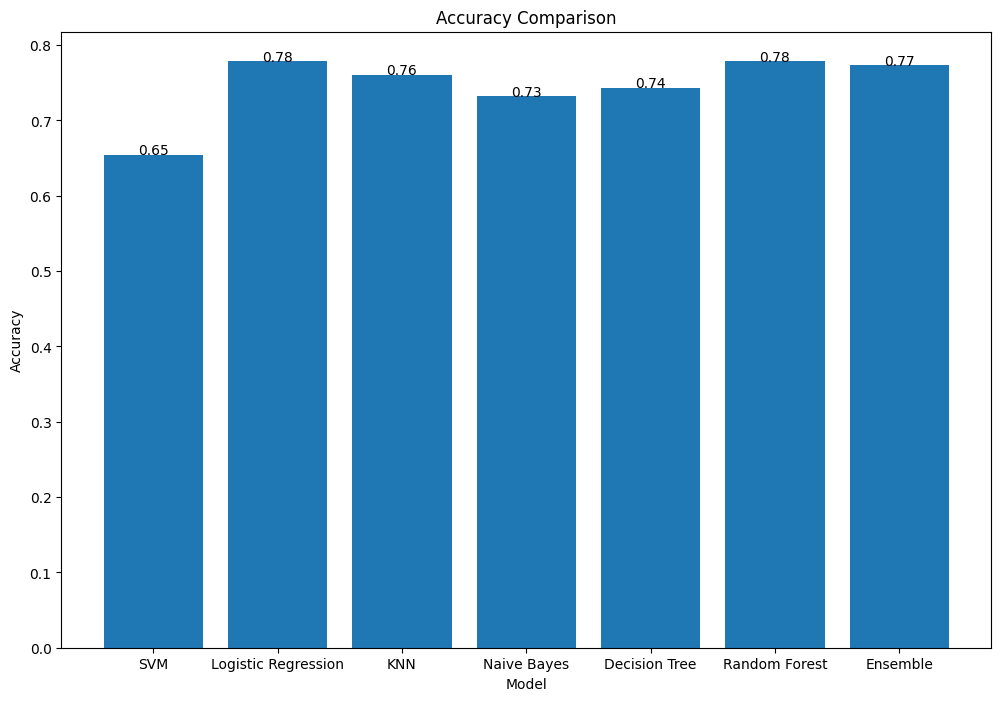

In [214]:
models = ["SVM","Logistic Regression", "KNN", "Naive Bayes", "Decision Tree", "Random Forest", "Ensemble"]

# Bar plot to comapre accuracies
plt.figure(figsize=(12, 8))
plt.bar(models, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy, f"{accuracy:.2f}", ha='center')
plt.show()

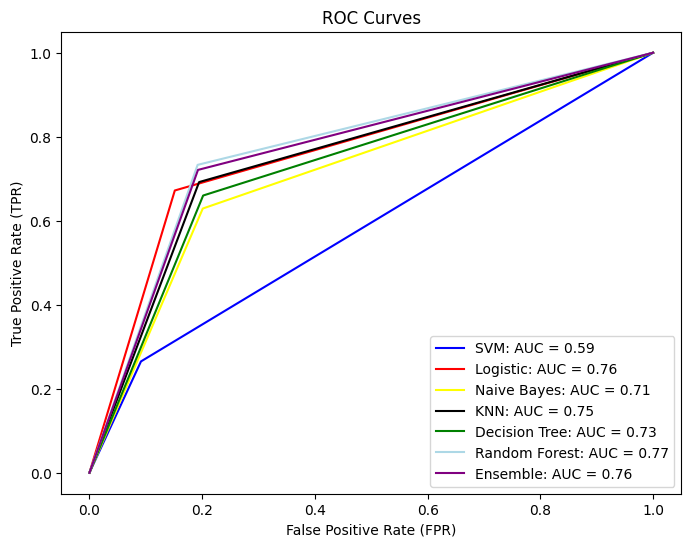

In [215]:
# Plot to compare the ROC curves of each model
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm_model, tpr_svm_model, color='blue', label=f'SVM: AUC = {auc_svm_model:.2f}')
plt.plot(fpr_lr_model, tpr_lr_model, color='red', label=f'Logistic: AUC = {auc_lr_model:.2f}')
plt.plot(fpr_nb_model, tpr_nb_model, color='yellow', label=f'Naive Bayes: AUC = {auc_nb_model:.2f}')
plt.plot(fpr_knn_model, tpr_knn_model, color='black', label=f'KNN: AUC = {auc_knn_model:.2f}')
plt.plot(fpr_dt_model, tpr_dt_model, color='green', label=f'Decision Tree: AUC = {auc_dt_model:.2f}')
plt.plot(fpr_rf_model, tpr_rf_model, color='lightblue', label=f'Random Forest: AUC = {auc_rf_model:.2f}')
plt.plot(fpr_v_model, tpr_v_model, color='purple', label=f'Ensemble: AUC = {auc_v_model:.2f}')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves')
plt.legend()
plt.show()